# **Final Project Task 1 - Census Data Preprocess**

Requirements

- Target variable specification:
    - The target variable for this project is hours-per-week. 
    - Ensure all preprocessing steps are designed to support regression analysis on this target variable.
- Encode data
- Handle missing values if any
- Correct errors, inconsistencies, remove duplicates if any
- Outlier detection and treatment if any
- Normalization / Standardization if necesarry
- Feature engineering
- Train test split, save it.
- Others?


Deliverable:

- Notebook code with no errors.
- Preprocessed data as csv.

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [390]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [391]:
# Understading the data
data.shape

(32561, 15)

In [392]:
print(data.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [393]:
# Check if the target variable has any missing data
data[data['hours-per-week'].isna()]

Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income]
Index: []

In [394]:
# Check for missing values
data.replace('?', np.nan, inplace=True)

missing_values = data.isnull().sum()
missing_values

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

- Missing values in dataset for variables 'workclass', 'occupation', 'native-country'

In [395]:
# Impute categorical features with the most frequent value - in case of any future data with missing values
cat_features = data.select_dtypes(include=["object"]).columns
num_features = data.select_dtypes(include=["int64", "float64"]).columns
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="mean")

data[cat_features] = cat_imputer.fit_transform(data[cat_features])
data[num_features] = num_imputer.fit_transform(data[num_features])

In [396]:
# Check if the missing values were successfully replaced

missing_values = data.isnull().sum()
missing_values

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [397]:
# Remove duplicates
data = data.drop_duplicates()

In [398]:
data.shape 

(32537, 15)

- 24 duplicates present and removed

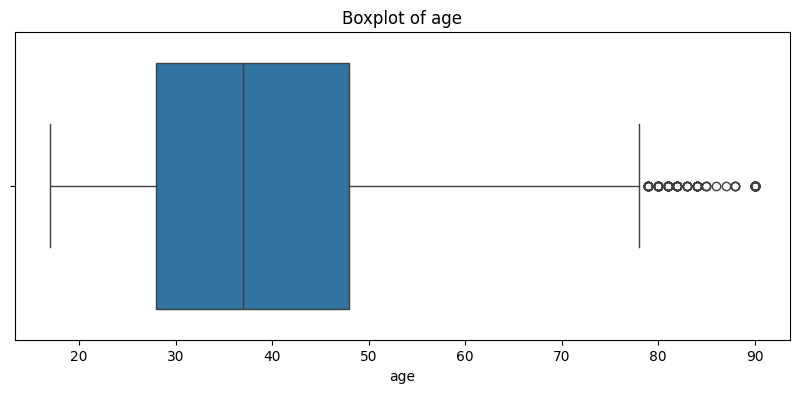

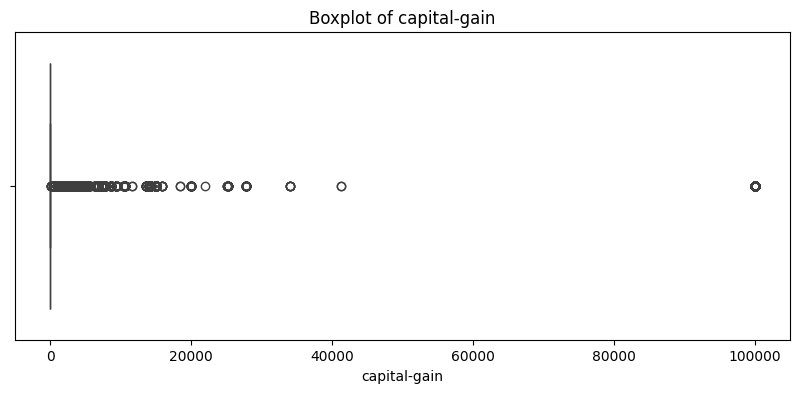

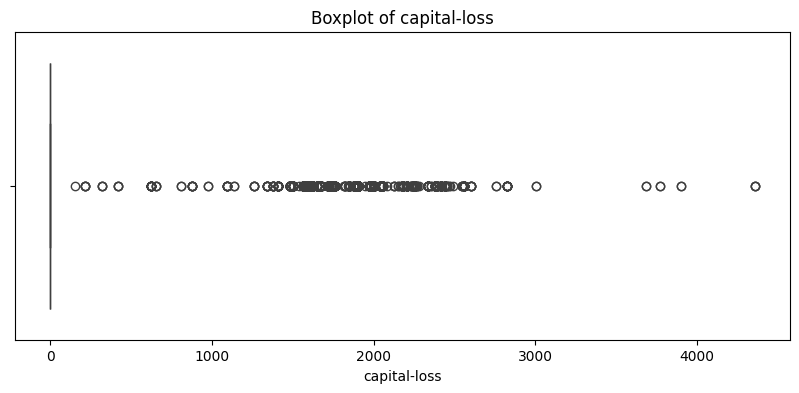

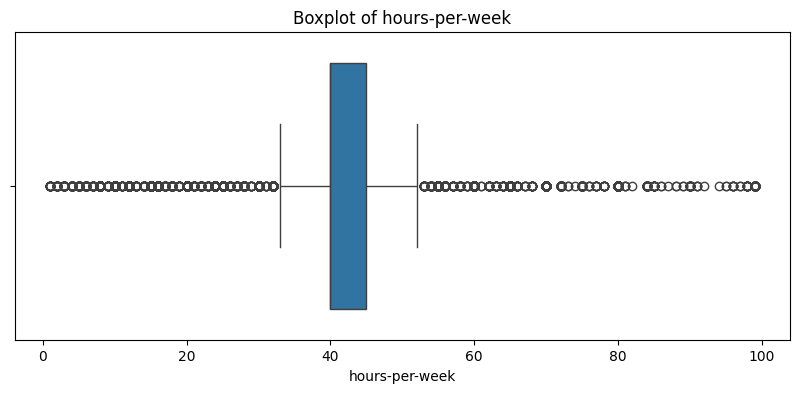

In [399]:
# Visualize data for outlier detection
features_to_check = ["age", "capital-gain", "capital-loss", "hours-per-week"]
for col in features_to_check:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

- **Boxplot of age**
  *  The median age is around 38–40 years, which aligns with the descriptive statistics.
  *  There are several outliers beyond 80 years, with some data points reaching close to 90 years.
  *  The distribution appears right-skewed, as the whisker on the upper end is longer.
  *  Outliers could represent elderly individuals still in the workforce, which might be legitimate but rare - ACTION: eliminate the individuals over 80 yo

- **Boxplot of capital-gain**
  *  A large concentration of data points is near zero, indicating that most individuals have little to no capital gain.
  *  There are extreme outliers reaching up to 100,000, with visible gaps between the upper whisker and these points.
  *  The distribution is highly right-skewed.
  *  These outliers likely represent individuals with exceptional investment returns or bonuses that could distort regression models if not handled properly. ACTION: ignoring 0 value as is the most common, an IQR-based capping will be applied on non-zero values.

- **Boxplot of capital-loss**
  *  Similar to capital-gain, there's a dense cluster near zero.
  *  Outliers extend up to around 4,300, with many isolated points beyond the whiskers.
  *  Indicates high skewness with rare but significant capital losses.
  *  ACTION: - ignoring 0 value as is the most common, an IQR-based capping will be applied on non-zero values.

- **Boxplot of hours-per-week**
  *  The median is at 40 hours, which reflects a standard full-time workweek.
  *  There are numerous outliers on both ends: Low end (<20 hours): Part-time workers or special work arrangements. High end (>60 hours): Overtime, multiple jobs, or high-demand roles.
  *  The distribution shows mild skewness with a concentration around 40–50 hours.
  *  ACTION: - extreme high values (>80 hours) will be capped.

In [400]:
# Outlier detection and treatment using IQR
# Remove outliers for age over 80
data = data[data['age'] <= 80]

In [401]:
# Apply IQR-based capping for capital-gain and capital-loss (excluding zeros)
#for col in ['capital-gain', 'capital-loss']:
    #non_zero_data = data[data[col] > 0][col]  # Exclude zeros for IQR calculation
    #Q1 = non_zero_data.quantile(0.25)
    #Q3 = non_zero_data.quantile(0.75)
    #IQR = Q3 - Q1
    #lower_bound = Q1 - 3 * IQR
    #upper_bound = Q3 + 3 * IQR

    #print(f"{col} - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

    #data.loc[:, col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    #data.loc[:, col] = np.where(data[col] > upper_bound, upper_bound, data[col])

In [402]:
# Handling Outliers for 'capital-gain' and 'capital-loss'
for col in ['capital-gain', 'capital-loss']:
    data[col] = np.where(data[col] > 0, np.log1p(data[col]), 0)  # Log transformation
    data[col] = winsorize(data[col], limits=[0.01, 0.01])        # Winsorization

In [403]:
# Cap extreme values for hours-per-week (above 80)
data.loc[:, 'hours-per-week'] = np.where(data['hours-per-week'] > 80, 80, data['hours-per-week'])


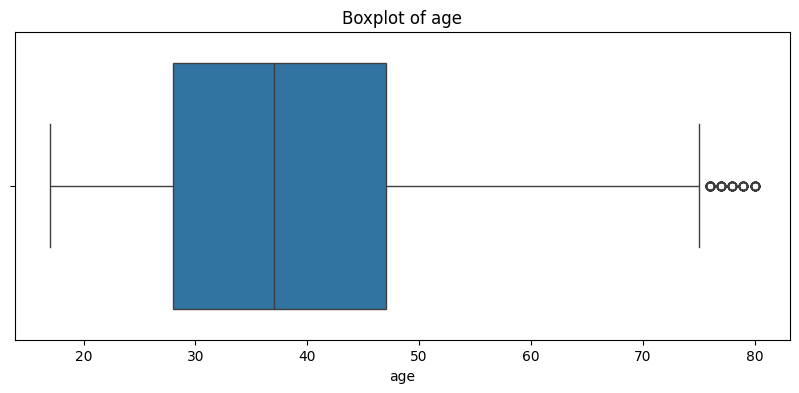

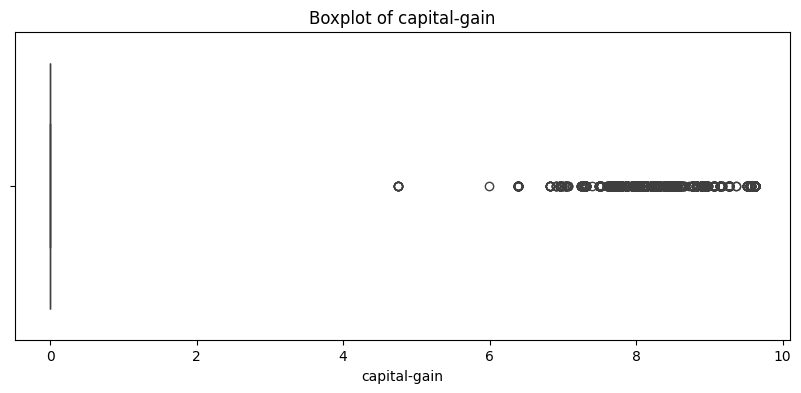

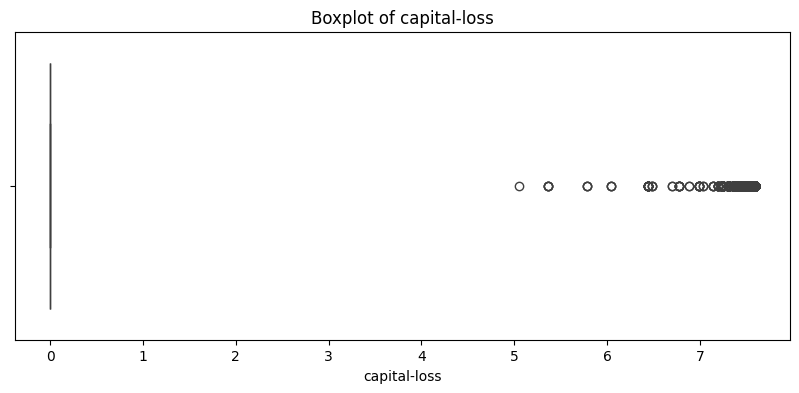

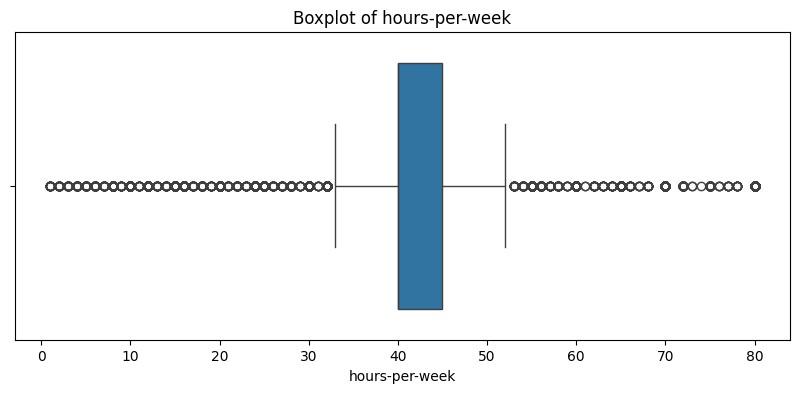

In [404]:
# Visualize data for outlier detection after modifications made
features_to_check = ["age", "capital-gain", "capital-loss", "hours-per-week"]
for col in features_to_check:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [405]:
# Binning Age
bins = [16, 24, 34, 54, 64, np.inf]
labels = ['Youth (17-24)', 'Early Career (25-34)', 'Mid Career (35-54)', 'Late Career (55-64)', 'Retirement Age (65+)']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

In [406]:
# Encoding categorical variables
# Display unique values for specified categorical variables
for col in ["workclass", "marital-status", "relationship", "race", "sex", "income", "age_group"]:
    print(f"Unique values in {col}: {data[col].unique()}\n")

Unique values in workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

Unique values in marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

Unique values in relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

Unique values in race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

Unique values in sex: ['Male' 'Female']

Unique values in income: ['<=50K' '>50K']

Unique values in age_group: ['Mid Career (35-54)', 'Early Career (25-34)', 'Youth (17-24)', 'Late Career (55-64)', 'Retirement Age (65+)']
Categories (5, object): ['Youth (17-24)' < 'Early Career (25-34)' < 'Mid Career (35-54)' < 'Late Career (55-64)' < 'Retirement Age (65+)']



In [407]:
# One-Hot Encoding of Categorical Variables (keeping original columns)
one_hot_features = ["workclass", "marital-status", "relationship", "race", "age_group"]
dummies = pd.get_dummies(data[one_hot_features], drop_first=True).astype(int)  

data = pd.concat([data, dummies], axis=1)

# Binary Encoding for 'sex'
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})

# Binary Encoding for 'income'
data['income'] = data['income'].str.strip().map({'<=50K': 0, '>50K': 1})

In [408]:
data.head(5)

age         workclass    fnlwgt  education  education-num  \
0  39.0         State-gov   77516.0  Bachelors           13.0   
1  50.0  Self-emp-not-inc   83311.0  Bachelors           13.0   
2  38.0           Private  215646.0    HS-grad            9.0   
3  53.0           Private  234721.0       11th            7.0   
4  28.0           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race  sex  ...  \
0       Never-married       Adm-clerical  Not-in-family  White    1  ...   
1  Married-civ-spouse    Exec-managerial        Husband  White    1  ...   
2            Divorced  Handlers-cleaners  Not-in-family  White    1  ...   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    1  ...   
4  Married-civ-spouse     Prof-specialty           Wife  Black    0  ...   

   relationship_Unmarried  relationship_Wife  race_Asian-Pac-Islander  \
0                       0                  0                        0   
1                       0                  0                        0   
2                       0                  0                        0   
3                       0                  0                        0   
4                       0                  1                        0   

  race_Black  race_Other race_White  age_group_Early Career (25-34)  \
0          0           0          1                               0   
1          0           0          1                               0   
2          0           0          1                               0   
3          1           0          0                               0   
4          1           0          0                               1   

   age_group_Mid Career (35-54)  age_group_Late Career (55-64)  \
0                             1                              0   
1                             1                              0   
2                             1                              0   
3                             1                              0   
4                             0                              0   

   age_group_Retirement Age (65+)  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  

[5 rows x 42 columns]

In [409]:
print(data['income'].unique())

[0 1]


In [410]:
# Addressing Multicollinearity
vif_data = pd.DataFrame()
numeric_data = data.select_dtypes(include=[np.number]).drop(columns=['hours-per-week'])  # Exclude target

vif_data['feature'] = numeric_data.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i)
                    for i in range(numeric_data.shape[1])]

# Remove features with high VIF (>5), excluding the target variable
high_vif_features = vif_data[vif_data['VIF'] > 5]['feature'].tolist()

print(high_vif_features)

['age', 'education-num', 'sex', 'workclass_Private', 'marital-status_Married-civ-spouse', 'relationship_Not-in-family', 'relationship_Own-child', 'relationship_Unmarried', 'race_Black', 'race_White', 'age_group_Mid Career (35-54)', 'age_group_Late Career (55-64)', 'age_group_Retirement Age (65+)']


In [411]:
# Combining Correlated Features (High VIF Variables)

# Create a ratio to understand education level relative to age
data['education_age_ratio'] = data['education-num'] / (data['age'] + 1)

# A binary feature indicating if the person lives independently
data['is_independent'] = np.where((data['marital-status_Married-civ-spouse'] == 0) & (data['relationship_Not-in-family'] == 1), 1, 0)

# Capital-net
data['capital_net'] = data['capital-gain'] - data['capital-loss']

# Gender roles in caregiving
data['male_with_own_child'] = np.where((data['sex'] == 1) & (data['relationship_Own-child'] == 1), 1, 0)

In [412]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'age_group', 'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
       'age_group_Early Career (25-34)', 'age_group_Mid Career (35-54)',
       'age_group_Late Career (55-64)', 'age_g

In [413]:
# 5. Normalization/Standardization (ignoring the string columns, binary variables, ordinal variables, and target variable)
#numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns
#binary_cols = [col for col in numeric_cols if data[col].nunique() == 2]
#exclude_cols = binary_cols + ['education-num', 'hours-per-week']
#continuous_cols = [col for col in numeric_cols if col not in exclude_cols]

In [414]:
data.head()

age         workclass    fnlwgt  education  education-num  \
0  39.0         State-gov   77516.0  Bachelors           13.0   
1  50.0  Self-emp-not-inc   83311.0  Bachelors           13.0   
2  38.0           Private  215646.0    HS-grad            9.0   
3  53.0           Private  234721.0       11th            7.0   
4  28.0           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race  sex  ...  \
0       Never-married       Adm-clerical  Not-in-family  White    1  ...   
1  Married-civ-spouse    Exec-managerial        Husband  White    1  ...   
2            Divorced  Handlers-cleaners  Not-in-family  White    1  ...   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    1  ...   
4  Married-civ-spouse     Prof-specialty           Wife  Black    0  ...   

   race_Other  race_White  age_group_Early Career (25-34)  \
0           0           1                               0   
1           0           1                               0   
2           0           1                               0   
3           0           0                               0   
4           0           0                               1   

  age_group_Mid Career (35-54)  age_group_Late Career (55-64)  \
0                            1                              0   
1                            1                              0   
2                            1                              0   
3                            1                              0   
4                            0                              0   

  age_group_Retirement Age (65+)  education_age_ratio  is_independent  \
0                              0             0.325000               1   
1                              0             0.254902               0   
2                              0             0.230769               1   
3                              0             0.129630               0   
4                              0             0.448276               0   

   capital_net  male_with_own_child  
0     7.684784                    0  
1     0.000000                    0  
2     0.000000                    0  
3     0.000000                    0  
4     0.000000                    0  

[5 rows x 46 columns]

In [415]:
# Define the desired variables
desired_vars = ['hours-per-week','age','fnlwgt','education-num','sex','capital-gain','capital-loss',
            'income','workclass_Local-gov','workclass_Never-worked','workclass_Private','workclass_Self-emp-inc',
            'workclass_Self-emp-not-inc','workclass_State-gov','workclass_Without-pay','marital-status_Married-AF-spouse',
            'marital-status_Married-civ-spouse','marital-status_Married-spouse-absent','marital-status_Never-married',
            'marital-status_Separated','marital-status_Widowed','relationship_Not-in-family','relationship_Other-relative',
            'relationship_Own-child','relationship_Unmarried','relationship_Wife','race_Asian-Pac-Islander',
            'race_Black','race_Other','race_White','education_age_ratio','is_independent','capital_net','male_with_own_child',
            'age_group_Early Career (25-34)', 'age_group_Mid Career (35-54)','age_group_Late Career (55-64)', 'age_group_Retirement Age (65+)'] 

In [416]:
# Select only the independent and dependent variables
data_final = data[desired_vars]
data_final.sample(5)

hours-per-week   age    fnlwgt  education-num  sex  capital-gain  \
15153            40.0  34.0  134737.0           13.0    1      0.000000   
15796            30.0  21.0  223352.0            9.0    0      6.962243   
6146             60.0  53.0  157881.0           10.0    1      0.000000   
7335             40.0  40.0   42703.0           11.0    0      0.000000   
19332            45.0  26.0  381618.0            5.0    1      0.000000   

       capital-loss  income  workclass_Local-gov  workclass_Never-worked  ...  \
15153           0.0       1                    0                       0  ...   
15796           0.0       0                    0                       0  ...   
6146            0.0       0                    0                       0  ...   
7335            0.0       0                    0                       0  ...   
19332           0.0       0                    0                       0  ...   

       race_Other  race_White  education_age_ratio  is_independent  \
15153           0           1             0.371429               0   
15796           0           1             0.409091               1   
6146            0           1             0.185185               1   
7335            0           1             0.268293               0   
19332           0           1             0.185185               0   

       capital_net  male_with_own_child  age_group_Early Career (25-34)  \
15153     0.000000                    1                               1   
15796     6.962243                    0                               0   
6146      0.000000                    0                               0   
7335      0.000000                    0                               0   
19332     0.000000                    0                               1   

       age_group_Mid Career (35-54)  age_group_Late Career (55-64)  \
15153                             0                              0   
15796                             0                              0   
6146                              1                              0   
7335                              1                              0   
19332                             0                              0   

       age_group_Retirement Age (65+)  
15153                               0  
15796                               0  
6146                                0  
7335                                0  
19332                               0  

[5 rows x 38 columns]

In [417]:
# Observe the entire preprocessed dataset
data_final.shape

(32439, 38)

In [418]:
#  Missing Values Analysis

# Replace '?' with NaN
data_final.replace('?', np.nan, inplace=True)

missing_data = data_final.isnull().sum()
missing_percentage = (missing_data / len(data_final)) * 100
missing_report = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
print(missing_report)

                                      Missing Values  Percentage
hours-per-week                                     0         0.0
age                                                0         0.0
fnlwgt                                             0         0.0
education-num                                      0         0.0
sex                                                0         0.0
capital-gain                                       0         0.0
capital-loss                                       0         0.0
income                                             0         0.0
workclass_Local-gov                                0         0.0
workclass_Never-worked                             0         0.0
workclass_Private                                  0         0.0
workclass_Self-emp-inc                             0         0.0
workclass_Self-emp-not-inc                         0         0.0
workclass_State-gov                                0         0.0
workclass_Without-pay    

C:\Users\bianc\AppData\Local\Temp\ipykernel_3820\3564811451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final.replace('?', np.nan, inplace=True)


In [419]:
# Save the preprocessed file
data_final.to_csv("full_preprocessed_data.csv", index=False)

In [420]:
# Now we will split the data into features (X) and labels (y).
# Create X & y values
X = data_final.drop("hours-per-week", axis=1)
y = data_final["hours-per-week"]

In [421]:
# Feature scaling: normalize data (values between 0 and 1)
# Create column transformer (this will help us normalize/preprocess our data)
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
ct = make_column_transformer(
    (StandardScaler(), ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'capital_net']), # Standardize using Z-score
)

In [422]:
# Build our train and test sets (use random state to ensure same split as before)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [423]:
# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'capital_net'])])

In [424]:
# Transform training data and test data with normalization (MinMaxScaler)
X_train_num = ct.transform(X_train)
X_test_num = ct.transform(X_test)

In [425]:
# Convert scaled numerical arrays back to DataFrame
X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_features)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_features)

In [426]:
# Create DataFrames from the transformed data
X_train_normal = pd.concat([X_train_num_df, X_train[categorical_features].reset_index(drop=True)], axis=1)
X_test_normal = pd.concat([X_test_num_df, X_test[categorical_features].reset_index(drop=True)], axis=1)

In [427]:
# Save the DataFrames as CSV files
X_train_normal.to_csv('X_train_normal.csv', index=False, header=True)
X_test_normal.to_csv('X_test_normal.csv', index=False, header=True)
# Save the target variables as well
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [428]:
# Recreate the preprocessed dataset with correct column names
train_data_normalized = pd.concat([X_train_normal, y_train.reset_index(drop=True)], axis=1)
test_data_normalized = pd.concat([X_test_normal, y_test.reset_index(drop=True)], axis=1)

# Save the corrected files
train_data_normalized.to_csv("train_preprocessed_normalized.csv", index=False)
test_data_normalized.to_csv("test_preprocessed_normalized.csv", index=False)